In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import max as tensor_max
import sys
from torch import Tensor, device, cuda, no_grad
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

In [5]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)


    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))
   

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

   

    return train_data, train_label, test_data, test_label

def info_log(log, verbosity=1):
    """
    Print information log
    :param log: log to be displayed
    :param verbosity: whether to show info log
    :return: None
    """
    if verbosity:
        print(f'[\033[96mINFO\033[00m] {log}')
        sys.stdout.flush()

In [10]:
class EEGNet(nn.Module):
    def __init__(self, activation, dropout=0.25):
        super().__init__()
        
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(dropout),
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(dropout),
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

    
class DeepConvNet(nn.Module):
    def __init__(self, activation,num_classes=2,dropout=0.5):
        super(DeepConvNet, self).__init__()
        
        # First Convolutional Block
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), bias=False),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Dropout(dropout),
        )
        
        # Second Convolutional Block
        self.conv_2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), bias=False),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Dropout(dropout),
        )
        
        # Third Convolutional Block
        self.conv_3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1), bias=False),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Dropout(dropout),
        )
        
        # Fourth Convolutional Block
        self.conv_4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1, 1), bias=False),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            activation(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Dropout(dropout),
        )
        
        # Flatten Layer
        self.flatten = nn.Flatten()
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(8600, 2 * num_classes),
            nn.Softmax(),
            nn.Dropout(dropout),
            nn.Linear(2 * num_classes, num_classes)
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
      
        
def show_result(target_model, epochs, accuracy, keys):
    longest = len(max(keys, key=len)) + 6
    plt.figure(0)
    if target_model == 'EEG':
        plt.title('Activation Function Comparison (EEGNet)')
    else:
        plt.title('Activation Function Comparison (DeepConvNet)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    

    for train_or_test, acc in accuracy.items():
        for model in keys:
            plt.plot(range(epochs), acc[model], label=f'{model}_{train_or_test}')
            spaces = ''.join([' ' for _ in range(longest - len(f'{model}_{train_or_test}'))])
            print(f'{model}_{train_or_test}: {spaces}{max(acc[model]):.2f} %')

    plt.legend(loc='lower right')
    plt.show()
    
    
accuracy_history_max = {}
accuracy_history_max['EEG_ELU'] = -1
accuracy_history_max['EEG_ReLU'] = -1
accuracy_history_max['EEG_LeakyReLU'] = -1
accuracy_history_max['Deep_ELU'] = -1
accuracy_history_max['Deep_ReLU'] = -1
accuracy_history_max['Deep_LeakyReLU'] = -1

########## Train ###########
def train(train_dataset, test_dataset, target_model='EEG', epochs=5, lr=0.01, optimizer=optim.Adam, batch_size=64,
          loss_function=nn.CrossEntropyLoss(), dropout=0.25, weight_decay=0.02, verbosity=1):

    info_log('Setup models', verbosity=verbosity)
    if target_model == 'EEG':
        models = {
            'EEG_ELU': EEGNet(nn.ELU).to(train_device),
            'EEG_ReLU': EEGNet(nn.ReLU).to(train_device),
            'EEG_LeakyReLU': EEGNet(nn.LeakyReLU).to(train_device)
        }
    else:
        models = {
            'Deep_ELU': DeepConvNet(nn.ELU, dropout=dropout).to(train_device),
            'Deep_ReLU': DeepConvNet(nn.ReLU, dropout=dropout).to(train_device),
            'Deep_LeakyReLU': DeepConvNet(nn.LeakyReLU, dropout=dropout).to(train_device)
        }

    # Setup accuracy structure
    info_log('Setup accuracy structure', verbosity=verbosity)
    keys = [f'{target_model}_ELU', f'{target_model}_ReLU', f'{target_model}_LeakyReLU']
    accuracy = {
        'train': {key: [0 for _ in range(epochs)] for key in keys},
        'test': {key: [0 for _ in range(epochs)] for key in keys}
    }

    # Start training
    info_log('Start training', verbosity=verbosity)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, len(test_dataset))
    for key, model in models.items():
        info_log(f'Training {key} ...', verbosity=verbosity)
        model_optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        best_epoch = -1

        for epoch in tqdm(range(epochs)):
            # Train model
            model.train()
            for data, label in train_loader:
                inputs = data.to(train_device)
                labels = label.to(train_device).long()

                pred_labels = model.forward(torch.tensor(inputs).float())

                model_optimizer.zero_grad()
                loss = loss_function(pred_labels, labels)
                loss.backward()
                model_optimizer.step()

                accuracy['train'][key][epoch] += (tensor_max(pred_labels, 1)[1] == labels).sum().item()
            accuracy['train'][key][epoch] = 100.0 * accuracy['train'][key][epoch] / len(train_dataset)

            # Test model
            model.eval()
            with no_grad():
                for data, label in test_loader:
                    inputs = data.to(train_device)
                    labels = label.to(train_device).long()

                    pred_labels = model.forward(torch.tensor(inputs).float())

                    accuracy['test'][key][epoch] += (tensor_max(pred_labels, 1)[1] == labels).sum().item()
                accuracy['test'][key][epoch] = 100.0 * accuracy['test'][key][epoch] / len(test_dataset)
                if accuracy_history_max[key] < accuracy['test'][key][epoch]:
#                     torch.save(model, f'{key}_model2.pth')
                    best_epoch = epoch
                    accuracy_history_max[key] = accuracy['test'][key][epoch]
#         print(best_epoch)
                        
        print()
        cuda.empty_cache()

    print(f'epochs:{epochs}, lr:{lr}, batch_size:{batch_size}, dropout:{dropout},optim:{optimizer}, weight_decay:{weight_decay}')
    show_result(target_model=target_model, epochs=epochs, accuracy=accuracy, keys=keys)


In [13]:
def evl(model_name):
    train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path = './'
    load_model = torch.load(path+model_name)
    key = model_name
    
    accuracy = 0
    
    train_data, train_label, test_data, test_label = read_bci_data()
    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_label))
    test_loader = DataLoader(test_dataset, len(test_dataset))
    with no_grad():
        for data, label in test_loader:
            inputs = data.to(train_device)
            labels = label.to(train_device).long()
            pred_labels = load_model.forward(torch.tensor(inputs).float())
            accuracy += (tensor_max(pred_labels, 1)[1] == labels).sum().item()
        accuracy = 100.0 * accuracy / len(test_dataset)
        spaces = ''.join([' ' for _ in range(20 - len(f'{model_name}_test'))])
        print(f'{model_name}_test: {spaces}{accuracy:.2f} %')
        
evl('EEG_ReLU_model2.pth')
evl('EEG_LeakyReLU_model2.pth')
evl('Deep_ELU_model2.pth')

EEG_ReLU_model2.pth_test: 87.41 %
EEG_LeakyReLU_model2.pth_test: 88.15 %
Deep_ELU_model2.pth_test: 82.13 %


/tmp/ipykernel_726113/371771036.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = load_model.forward(torch.tensor(inputs).float())


[INFO] Setup models
[INFO] Setup accuracy structure
[INFO] Start training
[INFO] Training EEG_ELU ...


  0%|                                                                                                                                                            | 0/800 [00:00<?, ?it/s]/tmp/ipykernel_726113/3986657662.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = model.forward(torch.tensor(inputs).float())
/tmp/ipykernel_726113/3986657662.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = model.forward(torch.tensor(inputs).float())
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:26<00:00, 29.87it/s]


[INFO] Training EEG_ReLU ...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:26<00:00, 30.32it/s]


[INFO] Training EEG_LeakyReLU ...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:26<00:00, 30.13it/s]



epochs:800, lr:0.001, batch_size:2048, dropout:0.3,optim:<class 'torch.optim.adamw.AdamW'>, weight_decay:0.02
EEG_ELU_train:       99.72 %
EEG_ReLU_train:      99.63 %
EEG_LeakyReLU_train: 99.72 %
EEG_ELU_test:        84.72 %
EEG_ReLU_test:       87.13 %
EEG_LeakyReLU_test:  87.50 %


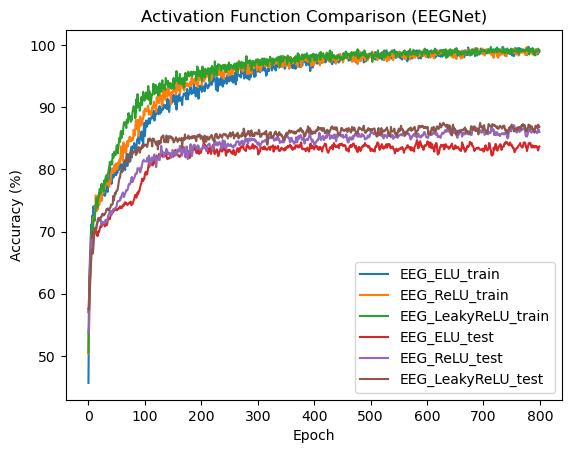

In [7]:
train_data, train_label, test_data, test_label = read_bci_data()
train_dataSet = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
test_dataSet = TensorDataset(torch.tensor(test_data), torch.tensor(test_label))
train(train_dataSet, test_dataSet, 
      target_model="EEG",
      epochs= 800, 
      dropout=0.3,
      optimizer=optim.AdamW,
      batch_size=2048,
      lr=1e-3)

[INFO] Setup models
[INFO] Setup accuracy structure
[INFO] Start training
[INFO] Training Deep_ELU ...


  0%|                                                                                                                                                            | 0/600 [00:00<?, ?it/s]/tmp/ipykernel_726113/3986657662.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = model.forward(torch.tensor(inputs).float())
/home/hcis-s20/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/tmp/ipykernel_726113/3986657662.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = model.forward(torch.


[INFO] Training Deep_ReLU ...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.10it/s]


[INFO] Training Deep_LeakyReLU ...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.12it/s]



epochs:600, lr:0.001, batch_size:256, dropout:0.25,optim:<class 'torch.optim.adamw.AdamW'>, weight_decay:0.02
Deep_ELU_train:       89.63 %
Deep_ReLU_train:      89.26 %
Deep_LeakyReLU_train: 89.72 %
Deep_ELU_test:        80.74 %
Deep_ReLU_test:       81.39 %
Deep_LeakyReLU_test:  79.63 %


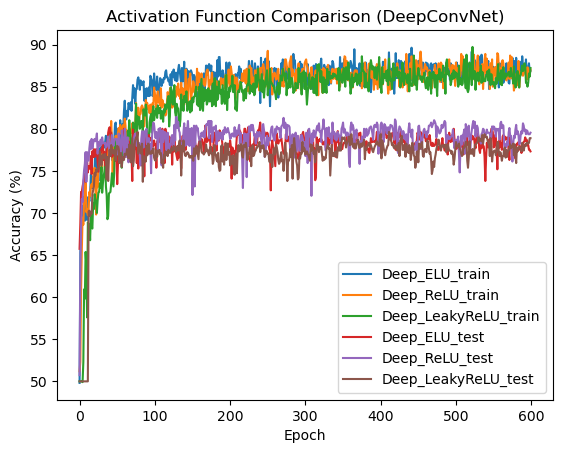

In [8]:
train_data, train_label, test_data, test_label = read_bci_data()
train_dataSet = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
test_dataSet = TensorDataset(torch.tensor(test_data), torch.tensor(test_label))
train(train_dataSet, test_dataSet, 
      target_model="Deep",
      epochs= 600, 
      dropout= 0.25,
      optimizer=optim.AdamW,
      batch_size=256,
      lr=1e-3)

[INFO] Setup models
[INFO] Setup accuracy structure
[INFO] Start training
[INFO] Training EEG_ELU ...


  0%|                                                                                                                                                            | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_726113/3986657662.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = model.forward(torch.tensor(inputs).float())
/tmp/ipykernel_726113/3986657662.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = model.forward(torch.tensor(inputs).float())
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.97it/s]


[INFO] Training EEG_ReLU ...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.93it/s]


[INFO] Training EEG_LeakyReLU ...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 30.71it/s]



epochs:300, lr:0.001, batch_size:256, dropout:0.25,optim:<class 'torch.optim.sgd.SGD'>, weight_decay:0.02
EEG_ELU_train:       76.67 %
EEG_ReLU_train:      76.30 %
EEG_LeakyReLU_train: 75.37 %
EEG_ELU_test:        72.41 %
EEG_ReLU_test:       73.06 %
EEG_LeakyReLU_test:  70.93 %


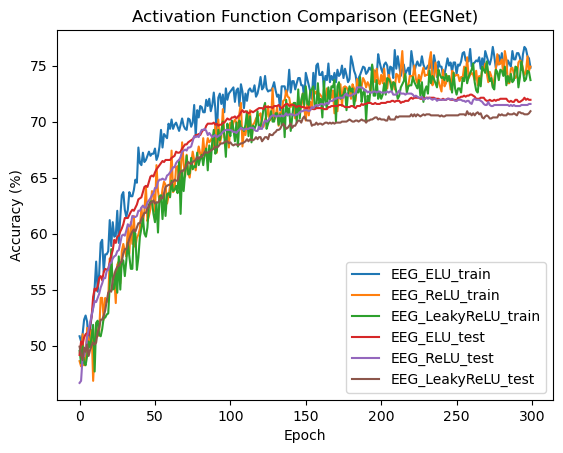

In [9]:
train_data, train_label, test_data, test_label = read_bci_data()
train_dataSet = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
test_dataSet = TensorDataset(torch.tensor(test_data), torch.tensor(test_label))
train(train_dataSet, test_dataSet, 
      target_model="EEG",
      epochs= 300, 
      dropout=0.25,
      optimizer=optim.SGD,
      batch_size=256,
      lr=1e-3)